In [49]:
import tabnanny

# Turn on verbose mode
tabnanny.verbose = 1

tabnanny.check("CancerDetection_Fourlayers.py")

'CancerDetection_Fourlayers.py': Clean bill of health.


In [11]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
#matplotlib.use("Agg")

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from keras.layers import Input
from CancerDetection import LeNet
#from CancerDetection_Fourlayers import LeNet
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os
import pickle

In [3]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 50
INIT_LR = 1e-3
BS = 32

# initialize the data and labels
print("[INFO] loading images...")
data = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images("images")))
random.seed(42)
random.shuffle(imagePaths)
# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    #print(image.shape)
    image = cv2.resize(image, (64, 64))
    image = img_to_array(image)
    data.append(image)

    # extract the class label from the image path and update the
    # labels list
    label = imagePath.split(os.path.sep)[-2] # Ex: images/Benign/gzl70.png
    #print("label........", label) # Malignant/Benign
    label = 1 if label == "Malignant" else 0
    labels.append(label)
    
    # scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

[INFO] loading images...


In [12]:
import pickle
pickle.dump(data, open("image_data.p", "wb"))

In [13]:
dataP = pickle.load(open("image_data.p","rb"))
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(dataP,
    labels, test_size=0.25, random_state=42)

In [14]:
# convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

[INFO] compiling model...
[INFO] training network...
Epoch 1/50
70/70 [==============================] - 3s 46ms/step - loss: 0.6990 - acc: 0.5952 - val_loss: 0.6382 - val_acc: 0.6310
Epoch 2/50
70/70 [==============================] - 3s 46ms/step - loss: 0.6088 - acc: 0.6606 - val_loss: 0.5751 - val_acc: 0.6997
Epoch 3/50
70/70 [==============================] - 3s 44ms/step - loss: 0.5582 - acc: 0.7003 - val_loss: 0.5460 - val_acc: 0.7209
Epoch 4/50
70/70 [==============================] - 3s 45ms/step - loss: 0.5534 - acc: 0.7058 - val_loss: 0.5556 - val_acc: 0.7077
Epoch 5/50
70/70 [==============================] - 3s 43ms/step - loss: 0.5362 - acc: 0.7353 - val_loss: 0.5551 - val_acc: 0.7288
Epoch 6/50
70/70 [==============================] - 3s 44ms/step - loss: 0.5444 - acc: 0.7235 - val_loss: 0.5511 - val_acc: 0.7169
Epoch 7/50
70/70 [==============================] - 3s 43ms/step - loss: 0.5433 - acc: 0.7102 - val_loss: 0.5966 - val_acc: 0.6442
Epoch 8/50
70/70 [============

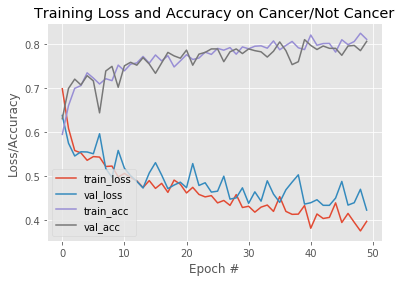

In [15]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=40, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, 
    horizontal_flip=True, fill_mode="nearest")

# initialize the model
print("[INFO] compiling model...")
#model = LeNet.build(width=64, height=64, depth=3, classes=2)
model = LeNet.build(64, 64, 3, 2)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS, 
    epochs=EPOCHS, verbose=1)

# save the model to disk
print("[INFO] serializing network...")
model.save("cancer_not_cancer.model")

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Cancer/Not Cancer")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [15]:
#                                     TESTING
# import the necessary packages
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
print("[INFO] loading network...")
model = load_model("cancer_not_cancer.model")

[INFO] loading network...


756/756 [==============================] - 0s 230us/step

acc: 80.69%
Malignant: 99.63%


-1

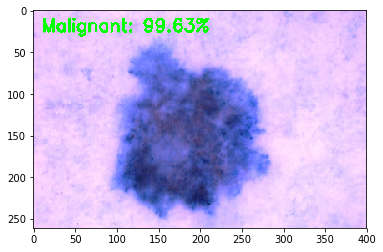

In [24]:
# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-m", "--model", required=True,
#	help="path to trained model model")
#ap.add_argument("-i", "--image", required=True,
#	help="path to input image")
#args = vars(ap.parse_args())

scores = model.evaluate(testX, testY)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# load the image
#image = cv2.imread("images/Benign/Trump.jpg")
#image = cv2.imread("images/Malignant/4023d.png")
image = cv2.imread("Test/Bm0300ad.png")
#image = cv2.imread("Test/Abl127.png")
#image = cv2.imread("images/Malignant/ISIC_0000074.jpg")
orig = image.copy()

# pre-process the image for classification
image = cv2.resize(image, (64, 64))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

# load the trained convolutional neural network


# classify the input image
(notCancer, cancer) = model.predict(image)[0]

# build the label
label = "Malignant" if cancer > notCancer else "Benign"
proba = cancer if cancer > notCancer else notCancer
label = "{}: {:.2f}%".format(label, proba * 100)

# draw the label on the image
output = imutils.resize(orig, width=400)
print(label)
#print(output)

cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
	0.7, (0, 255, 0), 2)

# show the output image
plt.imshow(output)
cv2.waitKey(0)